## Load and Examine Data

In [25]:
import matplotlib.pylab as plt
%matplotlib inline
import numpy as np
import tensorflow as tf

In [8]:
import tflearn.datasets.oxflower17 as oxflower17
X, Y = oxflower17.load_data(one_hot=True, resize_pics=(28,28))

Starting to parse images...
Parsing Done!


In [9]:
print X.shape
print Y.shape

(1360, 28, 28, 3)
(1360, 17)


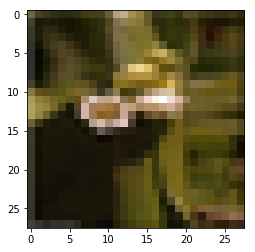

In [18]:
plt.imshow(X[30])

## GAN

In [28]:
def xavier_init(size):

    in_dim = size[0]

    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)

    return tf.random_normal(shape=size, stddev=xavier_stddev)

In [31]:
# Discriminator Net
X_ph = tf.placeholder(tf.float32, shape=[None, 2352], name='X')


X_tf = tf.convert_to_tensor(X, tf.float32)
X_mb = tf.train.batch([X_tf],mb_size)

D_W1 = tf.Variable(xavier_init([2352, 128]), name='D_W1')
D_b1 = tf.Variable(tf.zeros(shape=[128]), name='D_b1')

D_W2 = tf.Variable(xavier_init([128, 1]), name='D_W2')
D_b2 = tf.Variable(tf.zeros(shape=[1]), name='D_b2')

theta_D = [D_W1, D_W2, D_b1, D_b2]

# Generator Net
Z_ph = tf.placeholder(tf.float32, shape=[None, 100], name='Z')

G_W1 = tf.Variable(xavier_init([100, 128]), name='G_W1')
G_b1 = tf.Variable(tf.zeros(shape=[128]), name='G_b1')

G_W2 = tf.Variable(xavier_init([128, 2352]), name='G_W2')
G_b2 = tf.Variable(tf.zeros(shape=[2352]), name='G_b2')

theta_G = [G_W1, G_W2, G_b1, G_b2]


def generator(z):
    G_h1 = tf.nn.relu(tf.matmul(z, G_W1) + G_b1)
    G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
    G_prob = tf.nn.sigmoid(G_log_prob)

    return G_prob


def discriminator(x):
    D_h1 = tf.nn.relu(tf.matmul(x, D_W1) + D_b1)
    D_logit = tf.matmul(D_h1, D_W2) + D_b2
    D_prob = tf.nn.sigmoid(D_logit)

    return D_prob, D_logit

G_sample = generator(Z_ph)
D_real, D_logit_real = discriminator(X_ph)
D_fake, D_logit_fake = discriminator(G_sample)

D_loss = -tf.reduce_mean(tf.log(D_real) + tf.log(1. - D_fake))
G_loss = -tf.reduce_mean(tf.log(D_fake))

# Only update D(X)'s parameters, so var_list = theta_D
D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)
# Only update G(X)'s parameters, so var_list = theta_G
G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)

def sample_Z(m, n):
    '''Uniform prior for G(Z)'''
    return np.random.uniform(-1., 1., size=[m, n])



In [40]:
mb_size = 128

Z_dim = 100

sess = tf.Session()
sess.run(tf.global_variables_initializer())
for it in range(1000000):

    _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X_ph: X, Z_ph: sample_Z(mb_size, Z_dim)})
    _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={Z_ph: sample_Z(mb_size, Z_dim)})
    
    if it % 1000 == 0:
        print('Iter: {}'.format(it))
        print('D loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
        print()

ValueError: Cannot feed value of shape (1360, 28, 28, 3) for Tensor u'X_8:0', which has shape '(?, 2352)'